In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas
import time, json, requests, pprint, copy, math, dateutil
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh
import scipy.interpolate

from Exploring_Argo_BGC_with_Argovis_helpers import polygon_lon_lat,  padlist, varrange, interpolate, \
    simple_map, plot_xycol, argo_heatmap, hurrplot, compare_plots

# Exploring Argo BGC with Argovis

## Setup: Register an API key

In order to allocate Argovis's limited computing resources fairly, users are encouraged to register and request a free API key. This works like a password that identifies your requests to Argovis. To do so:

 - Visit [https://argovis-keygen.colorado.edu/](https://argovis-keygen.colorado.edu/)
 - Fill out the form under _New Account Registration_
 - An API key will be emailed to you shortly.
 
Treat this API key like a password - don't share it or leave it anywhere public. If you ever forget it or accidentally reveal it to a third party, see the same website above to change or deactivate your token.

Put your API key in the quotes in the variable below before moving on:

In [2]:
API_KEY=''
API_PREFIX = 'https://argovis-api.colorado.edu/'

# Downloading and plotting BGC data

Download all the BGC measurements in a region over a timespan and plot the profile locations on a map:

In [3]:
polygon = [[-75,42],[-75,38],[-62,38],[-62,42],[-75,42]]
params = {
        'startDate': '2021-01-01T00:00:00Z',
        'endDate': '2022-01-01T00:00:00Z',
        'source': 'argo_bgc',
        'polygon': polygon,
        'data': 'all'
    }

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/envs/argovis_demos/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


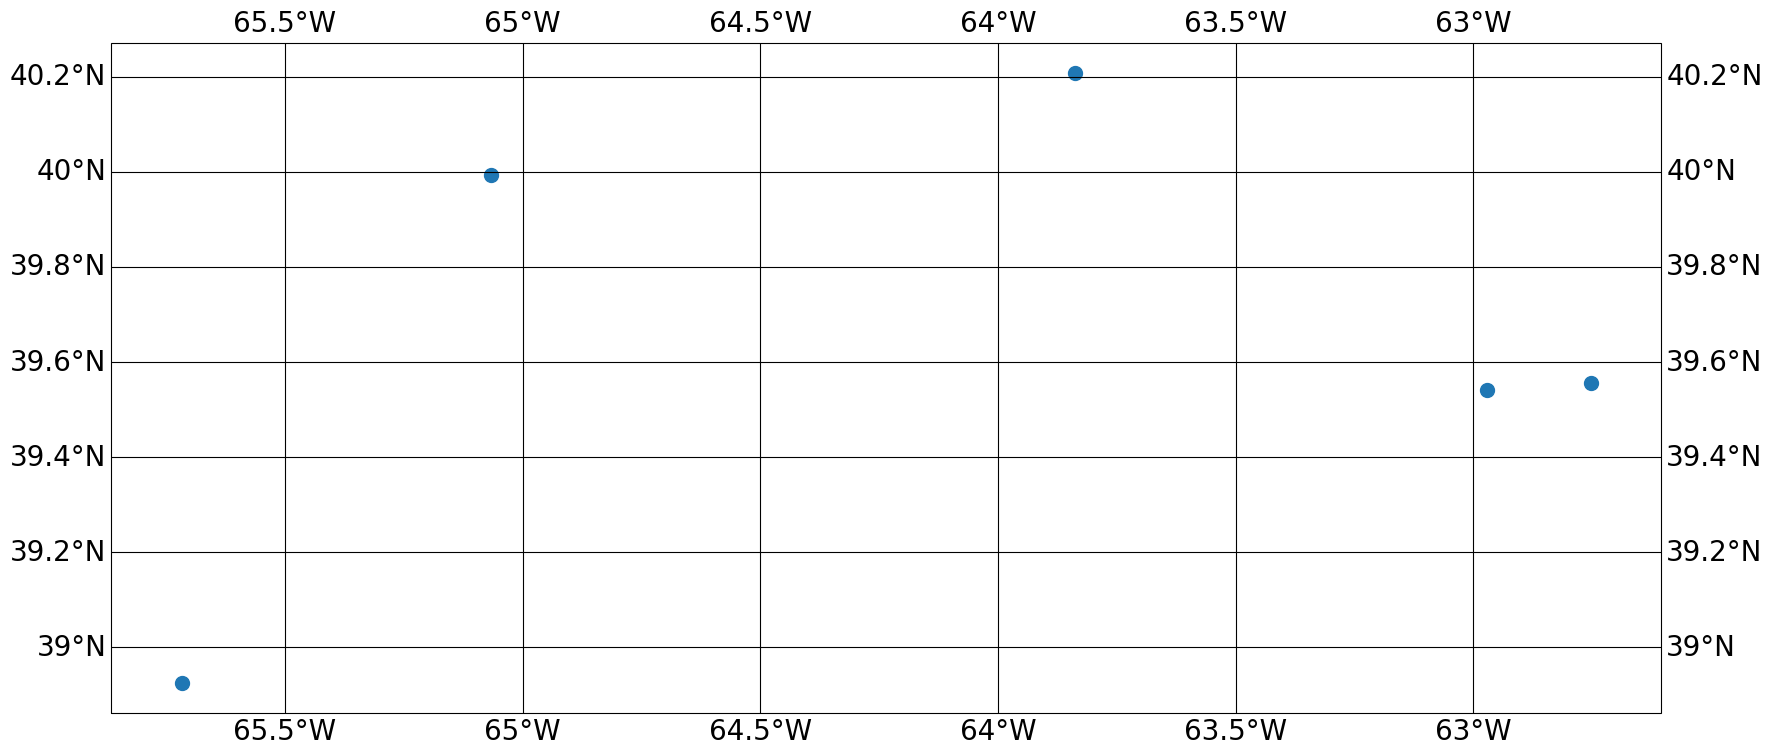

In [4]:
longitudes = [x['geolocation']['coordinates'][0] for x in d]
latitudes  = [x['geolocation']['coordinates'][1] for x in d]

simple_map(longitudes,latitudes)

Turn our data into a list of dataframes, and plot with color by QC:

In [5]:
dfs = [pandas.DataFrame.from_records([level for level in avh.data_inflate(profile)]) for profile in d]

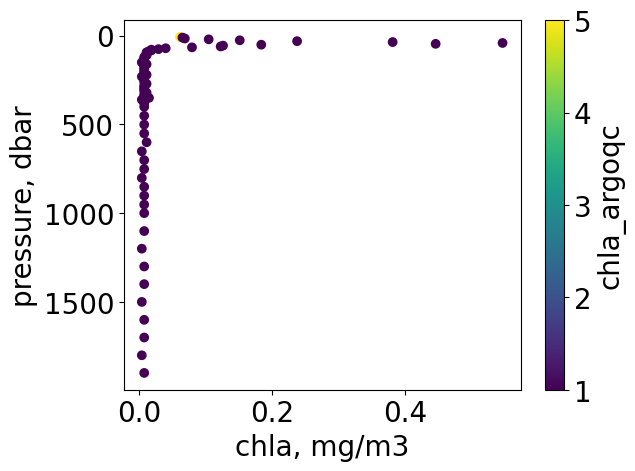

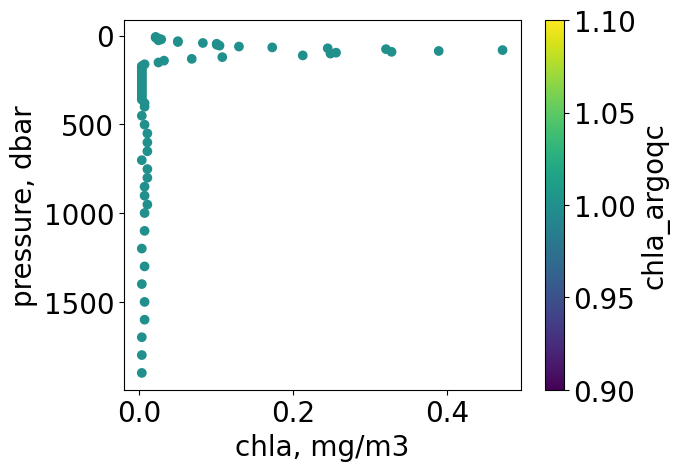

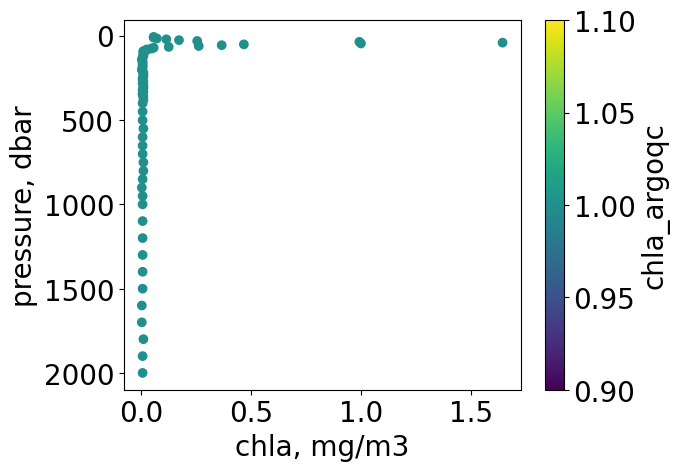

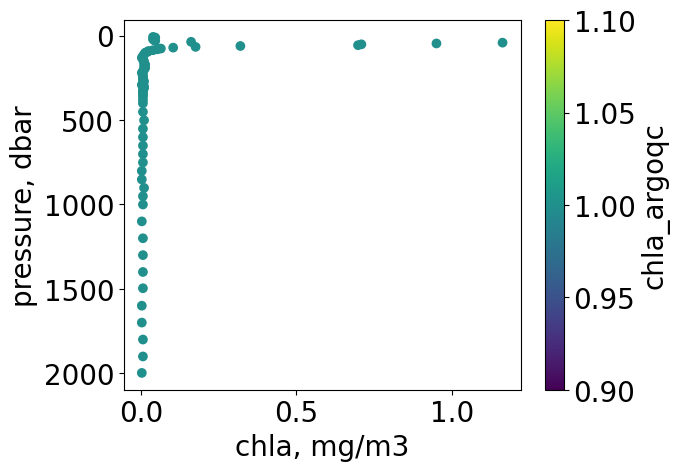

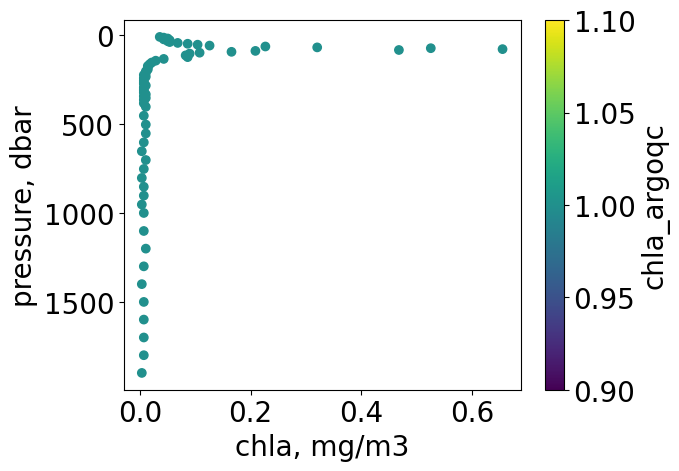

In [6]:
for df in dfs:
    plot_xycol(x=df['chla'],y=df['pressure'],d2col=df['chla_argoqc'], 
               x_tag='chla, mg/m3',y_tag='pressure, dbar',d2col_tag='chla_argoqc',fontsz = 20)

Or, filter by QC before plotting:

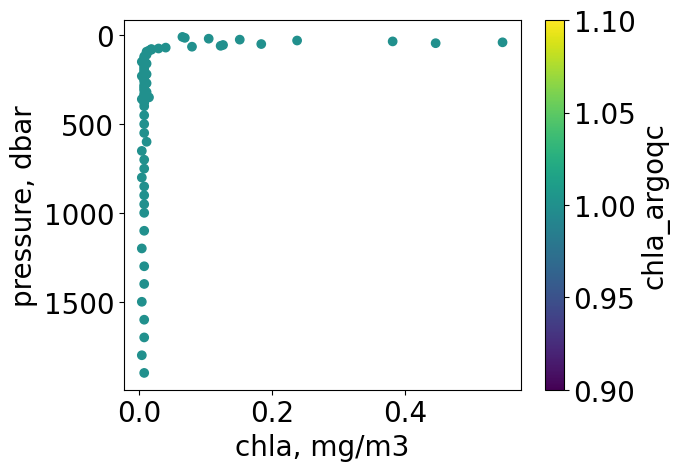

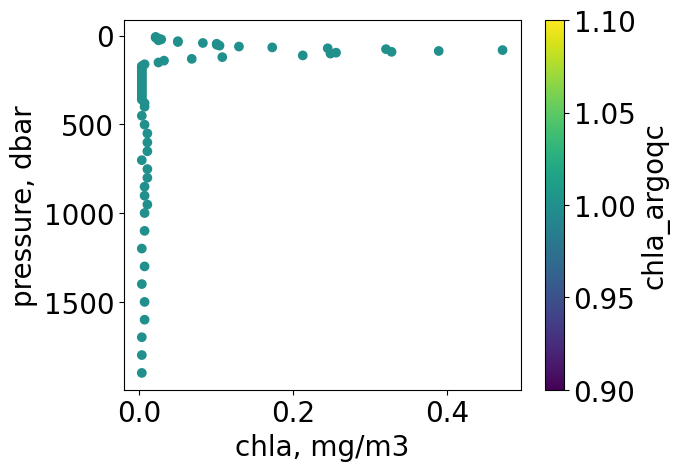

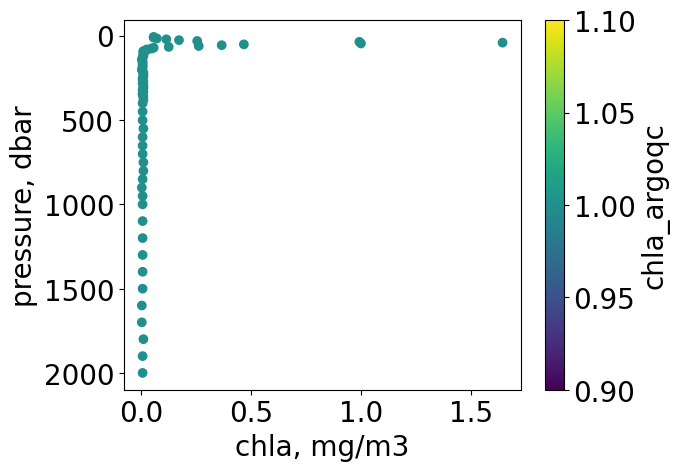

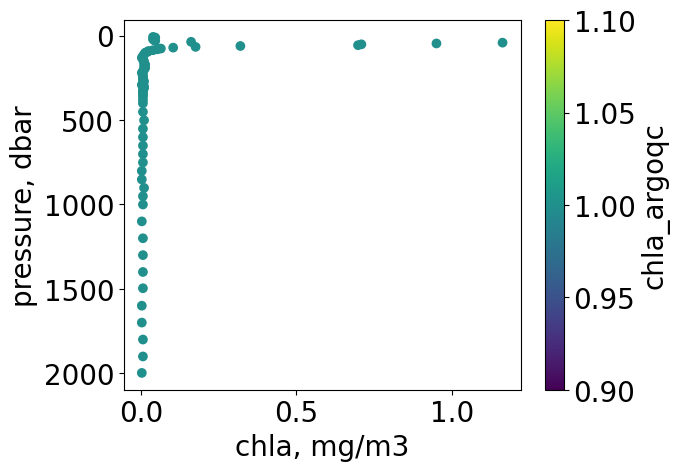

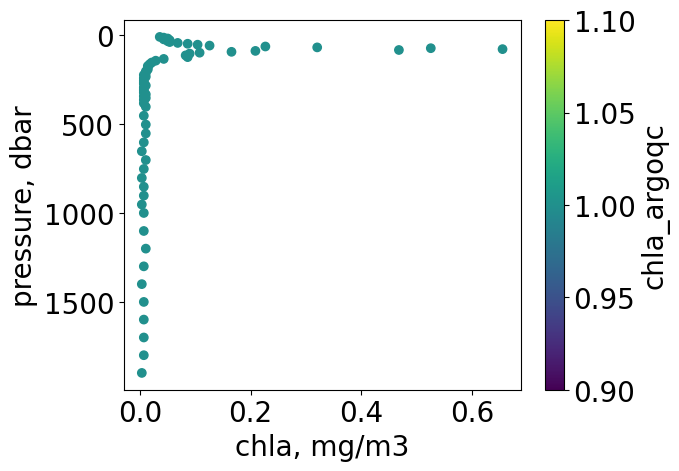

In [7]:
for df in dfs:
    df_qc = df[df['chla_argoqc'] == 1]
    plot_xycol(x=df_qc['chla'],y=df_qc['pressure'],d2col=df_qc['chla_argoqc'], 
               x_tag='chla, mg/m3',y_tag='pressure, dbar',d2col_tag='chla_argoqc',fontsz = 20)

Plot one variable against another:

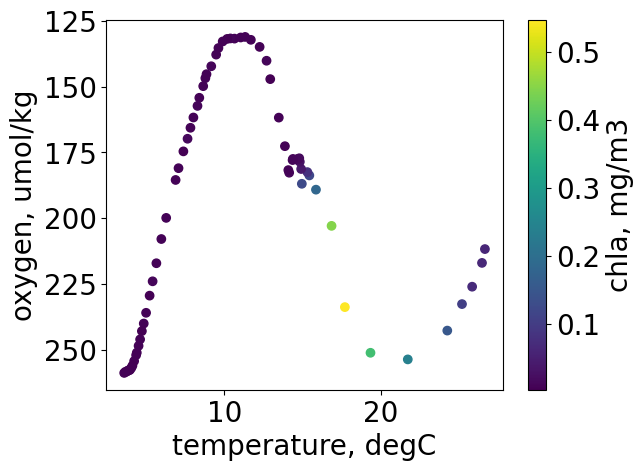

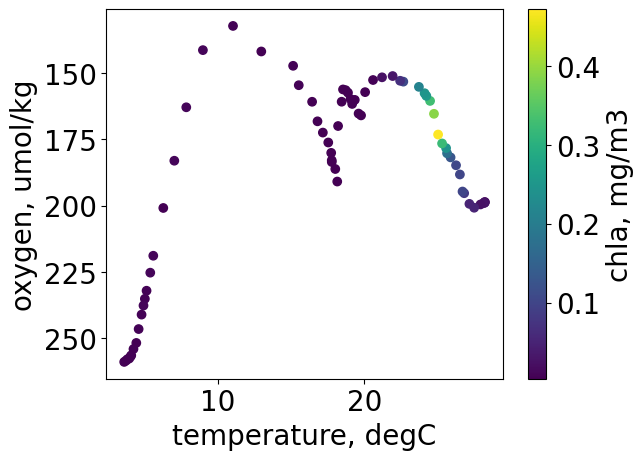

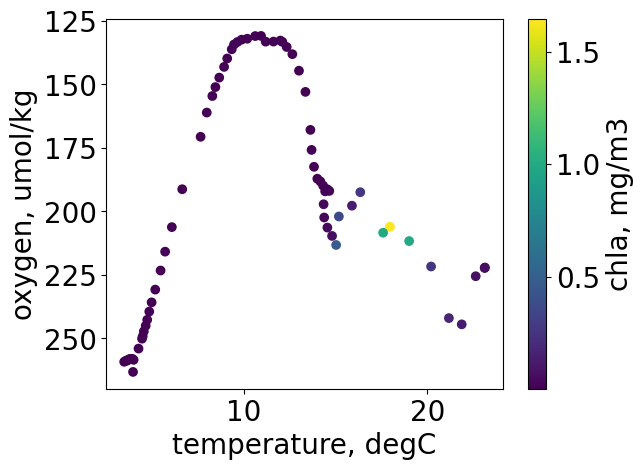

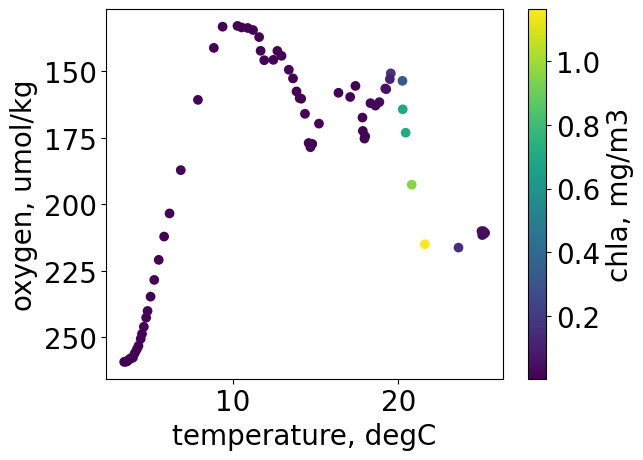

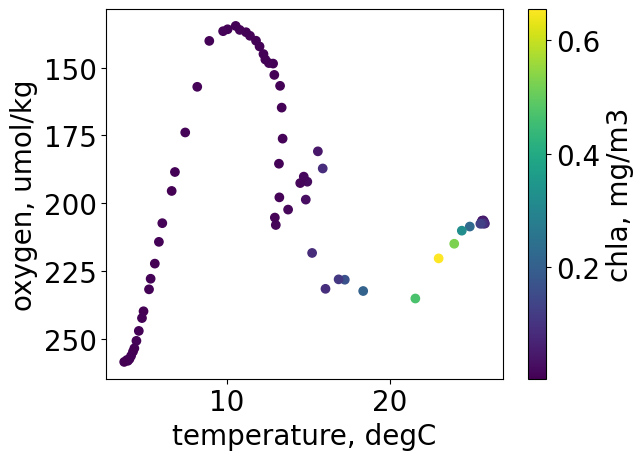

In [8]:
for df in dfs:
    plot_xycol(x=df['temperature_sfile'],y=df['doxy'],d2col=df['chla'], 
                          x_tag='temperature, degC',y_tag='oxygen, umol/kg',d2col_tag='chla, mg/m3',fontsz = 20)

List all BGC platforms, with some summary statistics:

In [9]:
bgc = requests.get(API_PREFIX + 'argo/bgc').json()
bgc[0]['summary'][0:10]

[{'_id': '6902963', 'n': 172, 'mostrecent': '2024-03-25T05:14:29.999Z'},
 {'_id': '4900497', 'n': 103, 'mostrecent': '2007-02-25T16:11:00.000Z'},
 {'_id': '7900584', 'n': 51, 'mostrecent': '2024-03-16T10:34:00.000Z'},
 {'_id': '6902908', 'n': 530, 'mostrecent': '2024-03-20T15:26:00.000Z'},
 {'_id': '6901688', 'n': 404, 'mostrecent': '2020-03-30T04:46:00.000Z'},
 {'_id': '5904981', 'n': 34, 'mostrecent': '2017-12-16T01:23:50.000Z'},
 {'_id': '6903824', 'n': 96, 'mostrecent': '2024-03-23T01:55:29.999Z'},
 {'_id': '2903172', 'n': 427, 'mostrecent': '2016-05-05T16:25:39.000Z'},
 {'_id': '2902216', 'n': 197, 'mostrecent': '2023-07-24T02:33:56.999Z'},
 {'_id': '4900345', 'n': 221, 'mostrecent': '2007-06-22T05:20:17.999Z'}]

Plot map of all BGC profile locations in 10 day span:

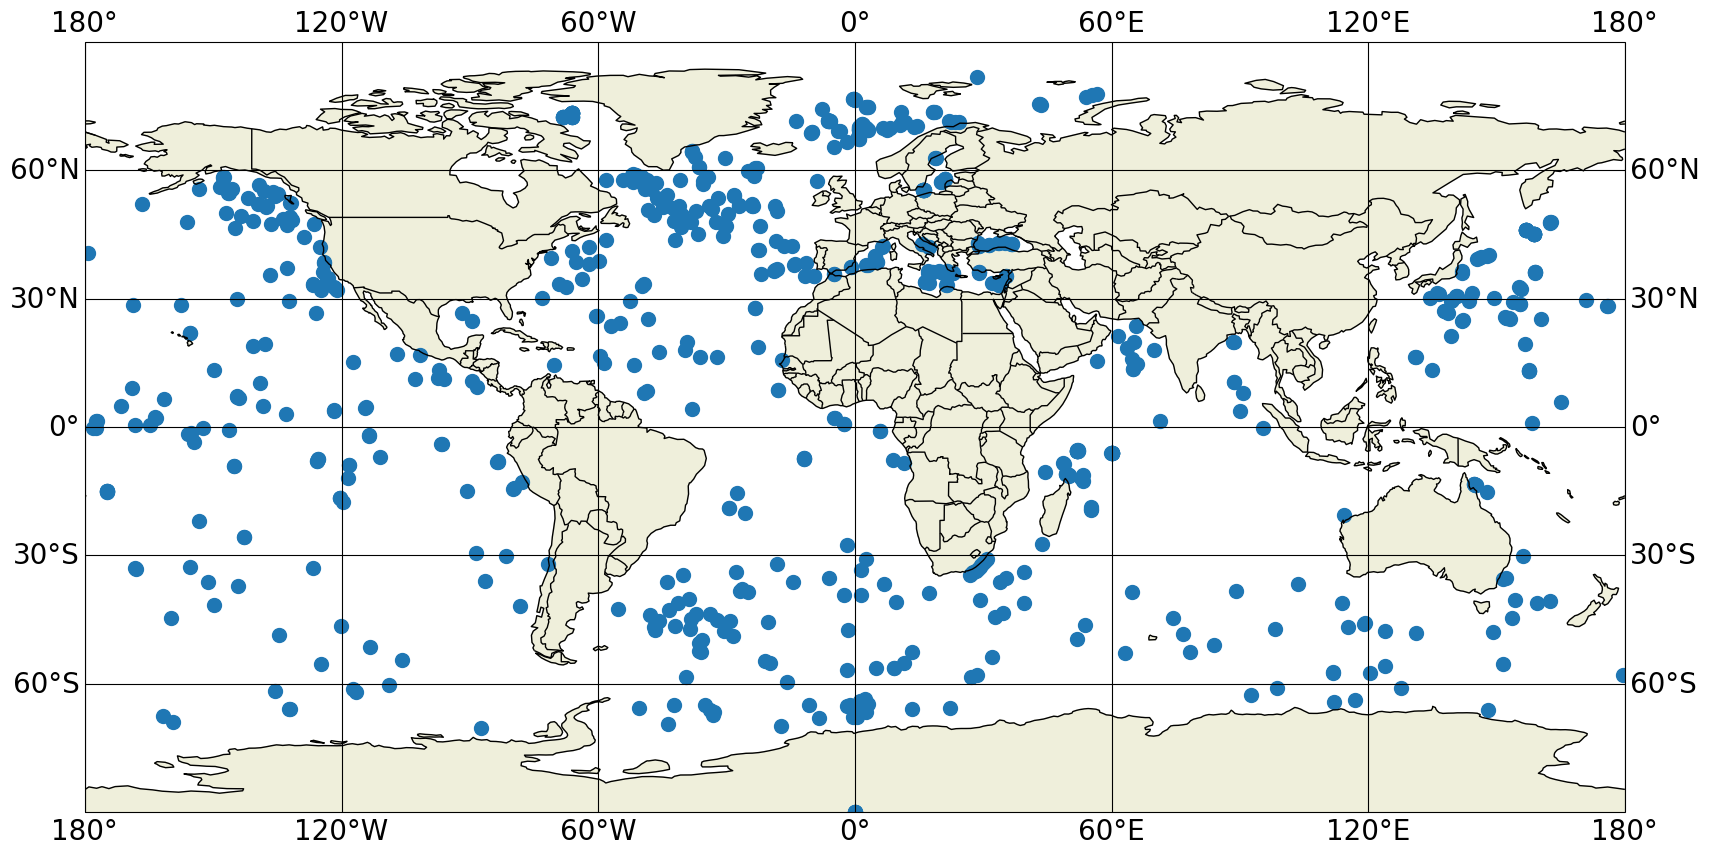

In [10]:
params = {
        'startDate': '2022-10-31T00:00:00Z',
        'endDate': '2022-11-11T00:00:00Z',
        'source': 'argo_bgc'
    }

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)
longitudes = [x['geolocation']['coordinates'][0] for x in d]
latitudes  = [x['geolocation']['coordinates'][1] for x in d]

simple_map(longitudes,latitudes)

Query what variables are available for a certain platform

In [11]:
params = {
       'platform': '6902740'
    }

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

In [12]:
variables = set({})
for i in range(len(d)):
    if 'data_info' in d[i]:
        variables.update(d[i]['data_info'][0])
print(variables)

{'down_irradiance412', 'cdom_argoqc', 'down_irradiance380', 'chla_fluorescence', 'temperature', 'cdom', 'chla_fluorescence_argoqc', 'salinity', 'doxy', 'bbp700_argoqc', 'pressure', 'temperature_sfile', 'salinity_sfile_argoqc', 'chla', 'down_irradiance490_argoqc', 'temperature_argoqc', 'bbp700', 'doxy_argoqc', 'chla_argoqc', 'temperature_sfile_argoqc', 'downwelling_par', 'down_irradiance412_argoqc', 'pressure_argoqc', 'salinity_sfile', 'salinity_argoqc', 'downwelling_par_argoqc', 'down_irradiance380_argoqc', 'down_irradiance490'}


Query a platform and plot data for a variable of interest.  The data is first interpolated onto a regular vertical grid and then a shaded plot of time vs pressure is shown. 

> **Downloading only what you need:**
BGC probes measure many parameters, often over many levels. Your downoads will often be dramatically faster if you specify your variables of interest, as in the example below, rather than using `data=all` unnecessarily. Recall that the `data` parameter can also accept a comma-separated list of variable names, if there are a few that you'd like.

In [13]:
params = {
    'platform': '6902740',
    'data': 'doxy'
}

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

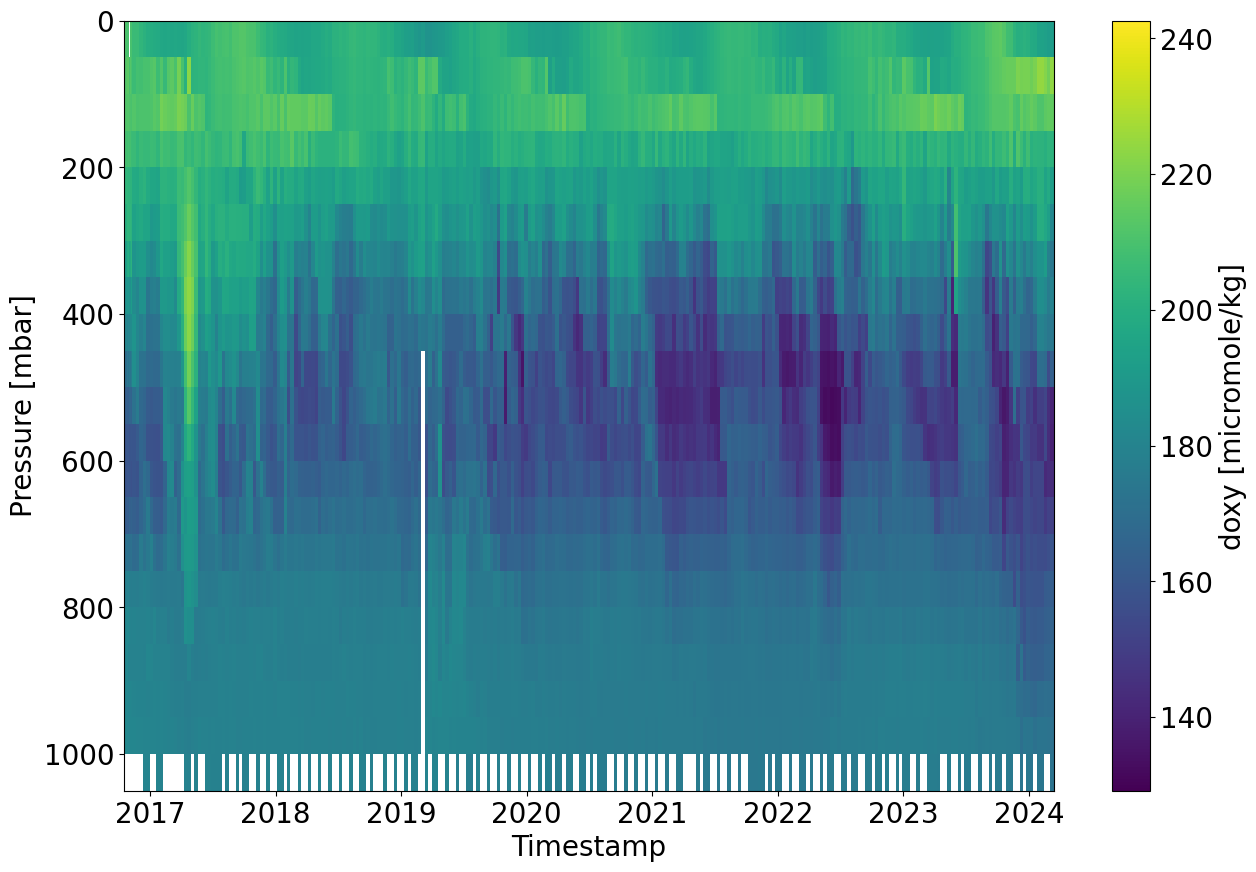

In [14]:
argo_heatmap(d, 'doxy', list(range(0,1001))[0::50])

# Colocating BGC profiles with other data

We can co-locate Argo BGC profiles with other measurements and phenomena, like tropical cyclones. For example, let's find all the BGC profiles near hurricane Maria in 2017, and plot some BGC measurements before and after the hurricane passed:

In [15]:
tc_param = {
    'startDate': '2017-09-01T00:00:00Z',
    'endDate': '2017-10-01T00:00:00Z',
    'name': 'MARIA',
    'data': 'wind,surface_pressure'
}

tc = avh.query('tc', options=tc_param, apikey=API_KEY, apiroot=API_PREFIX)

tc_lon = [x['geolocation']['coordinates'][0] for x in tc]
tc_lat = [x['geolocation']['coordinates'][1] for x in tc]
tc_wind = [x['data'][x['data_info'][0].index('wind')][0] for x in tc]

In [16]:
argo_bgc = []

for h in tc:
    colo_argo = {
        'center': str(h['geolocation']['coordinates'][0]) + ',' + str(h['geolocation']['coordinates'][1]),
        'radius': 52,
        'startDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=-6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'endDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'data': 'all',
        'source': 'argo_bgc'
    }
    p = avh.query('argo', options=colo_argo, apikey=API_KEY, apiroot=API_PREFIX)

    if len(p) == 0:
        argo_bgc.append(None)
    else:
        print('Profile found adjacent to', h['geolocation']['coordinates'][0], h['geolocation']['coordinates'][1])
        argo_bgc.append(p)

Profile found adjacent to -70.9 21.9
Profile found adjacent to -70.5 21.2
Profile found adjacent to -70 20.8


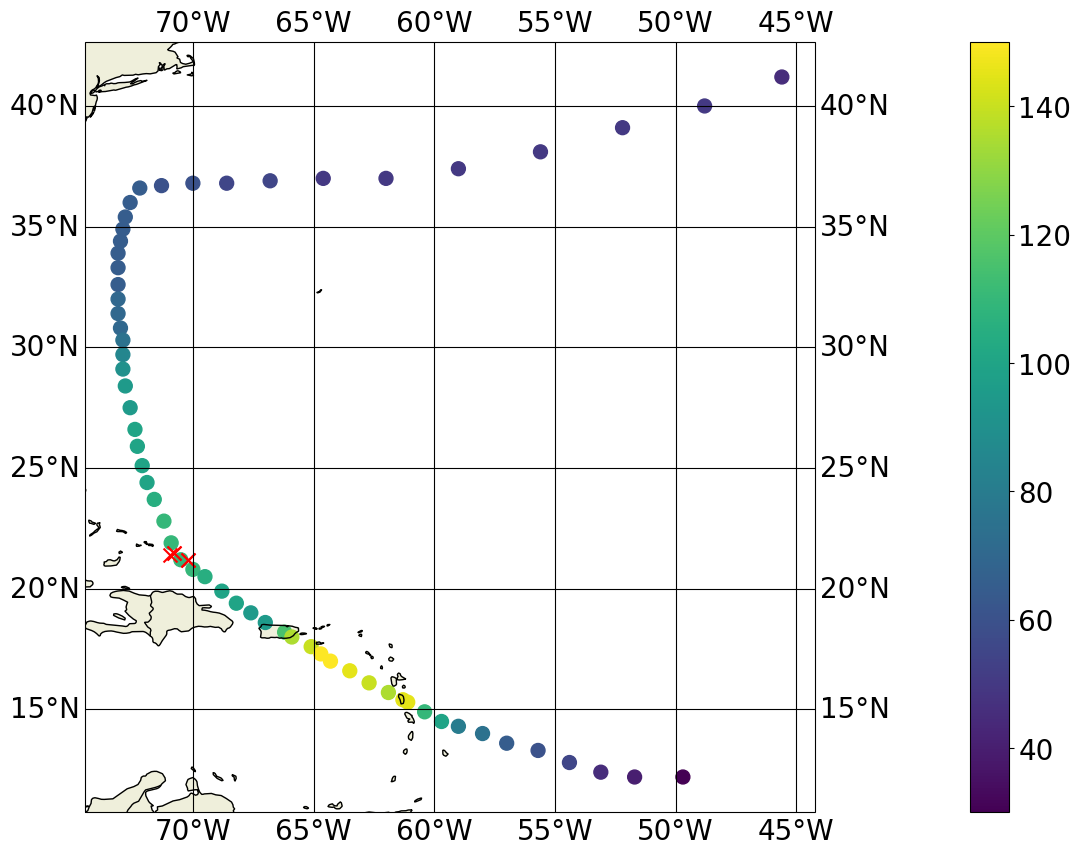

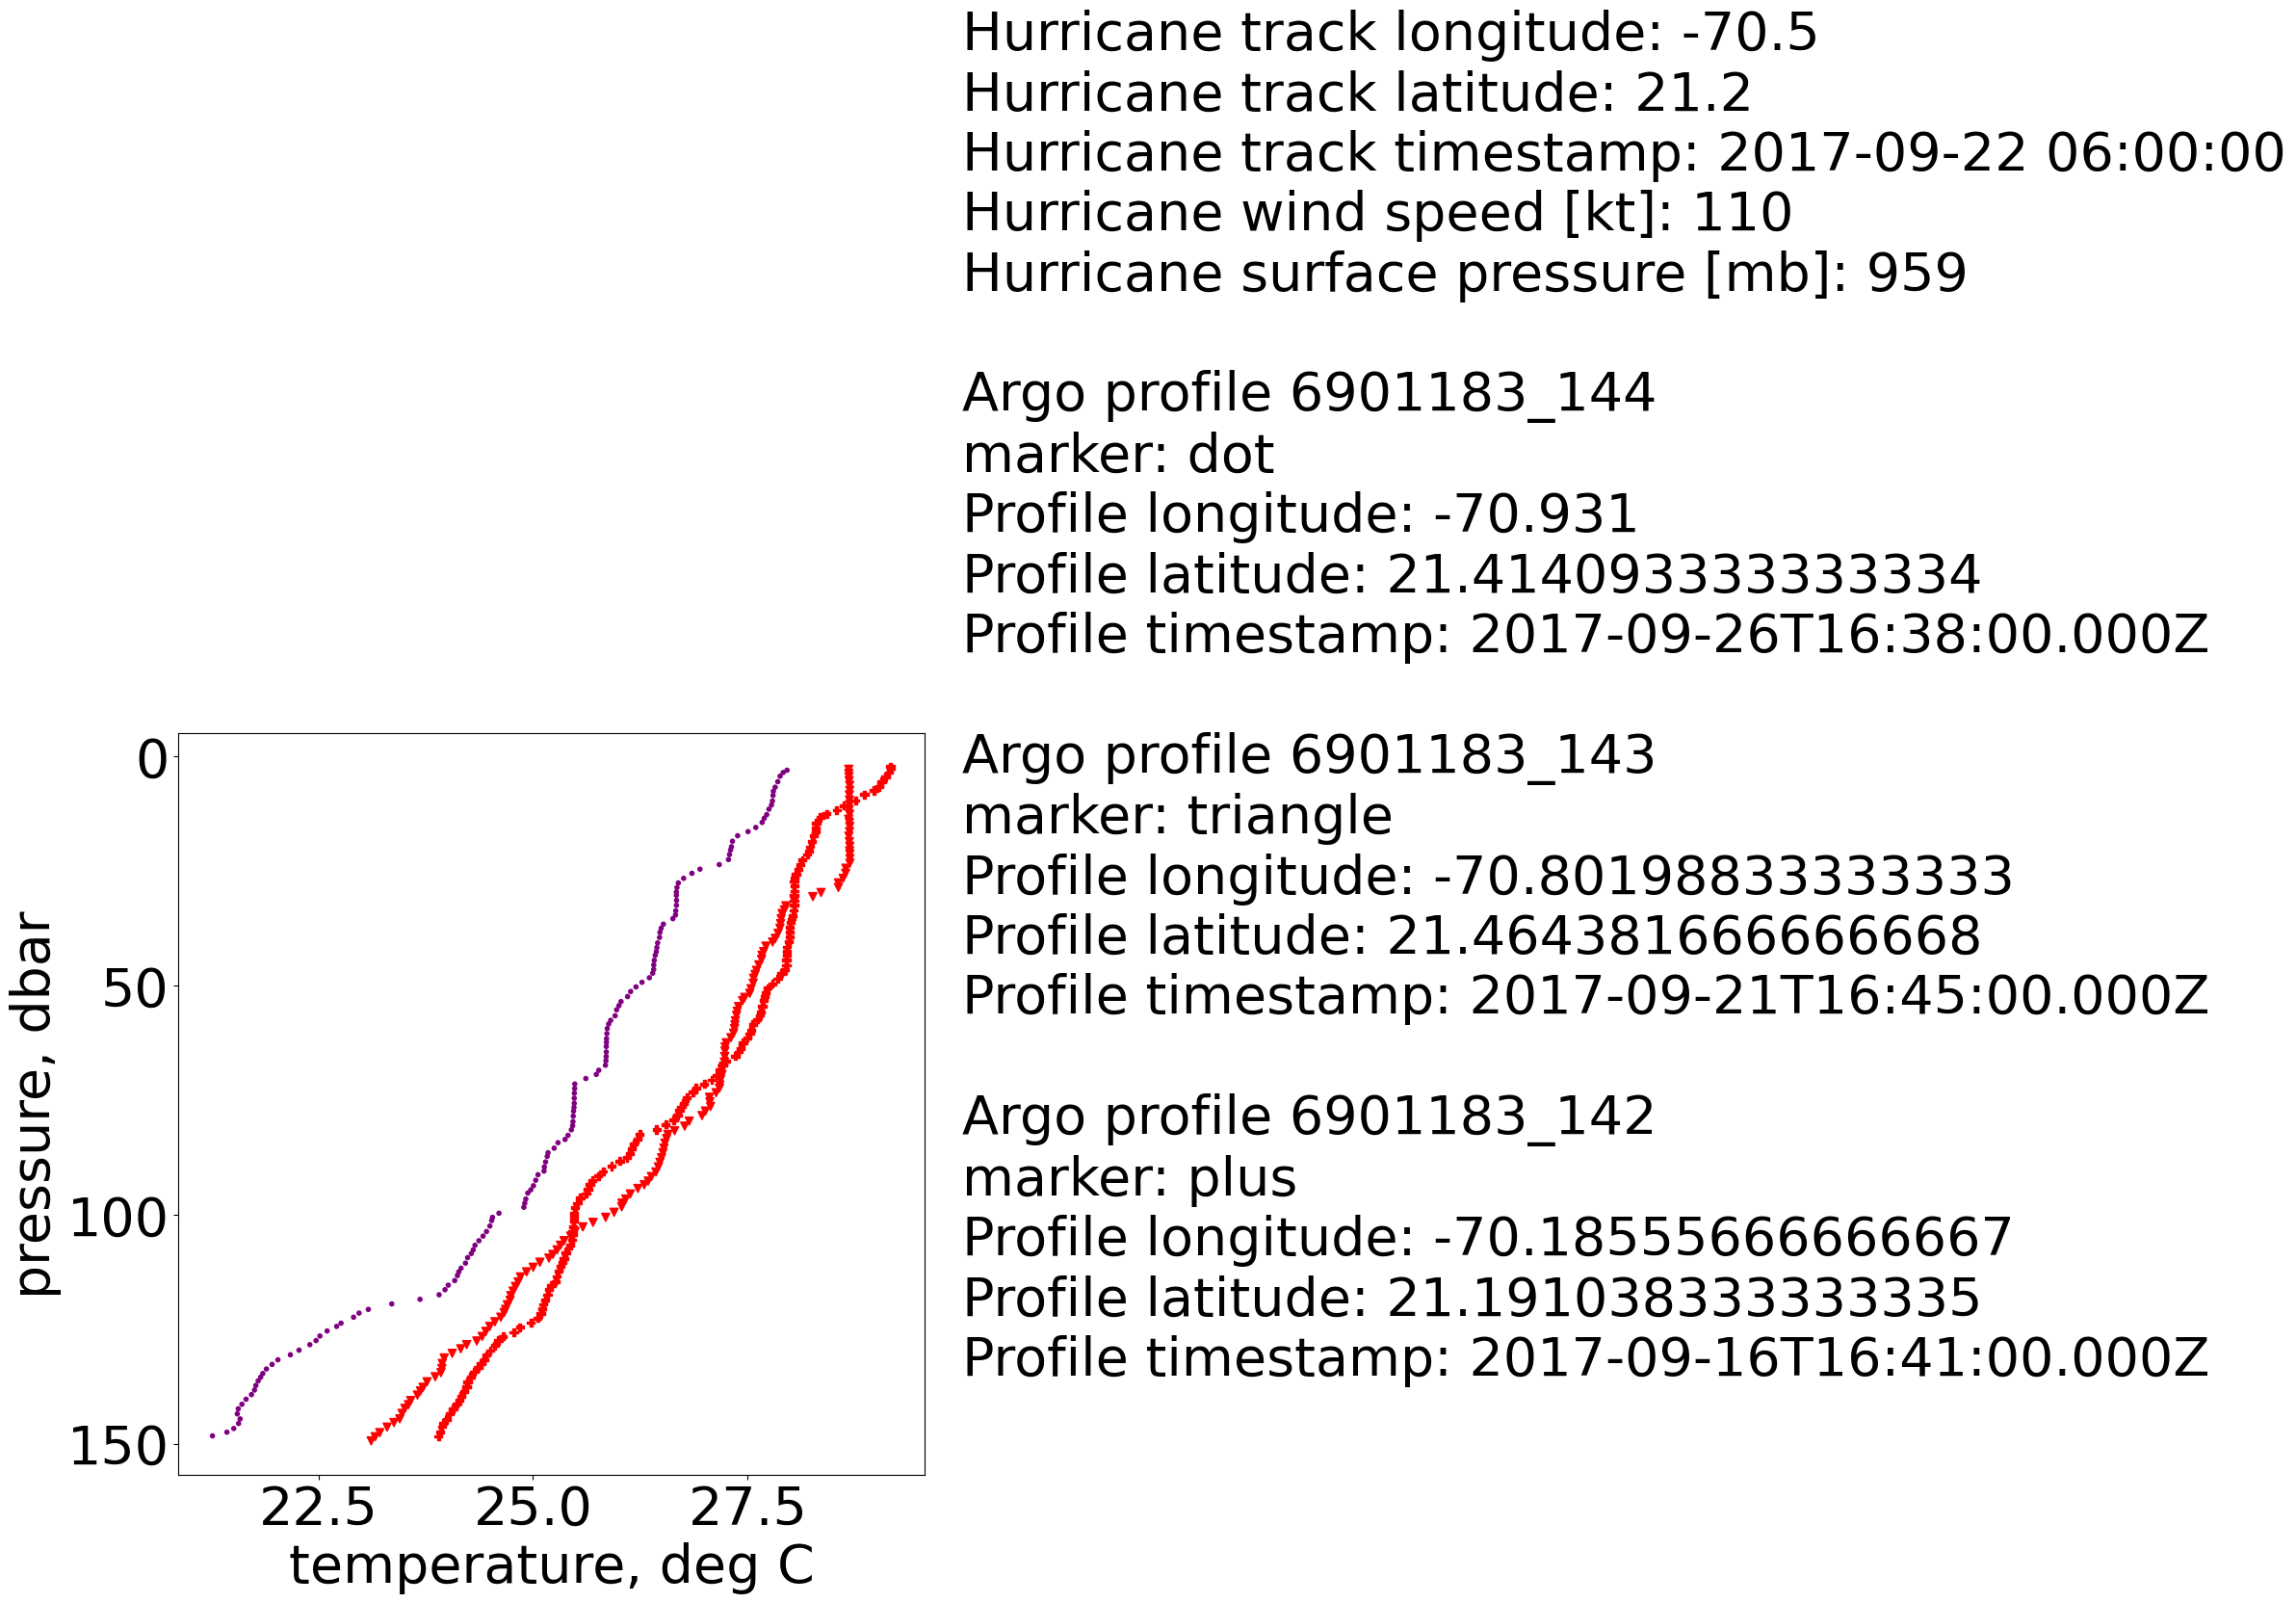

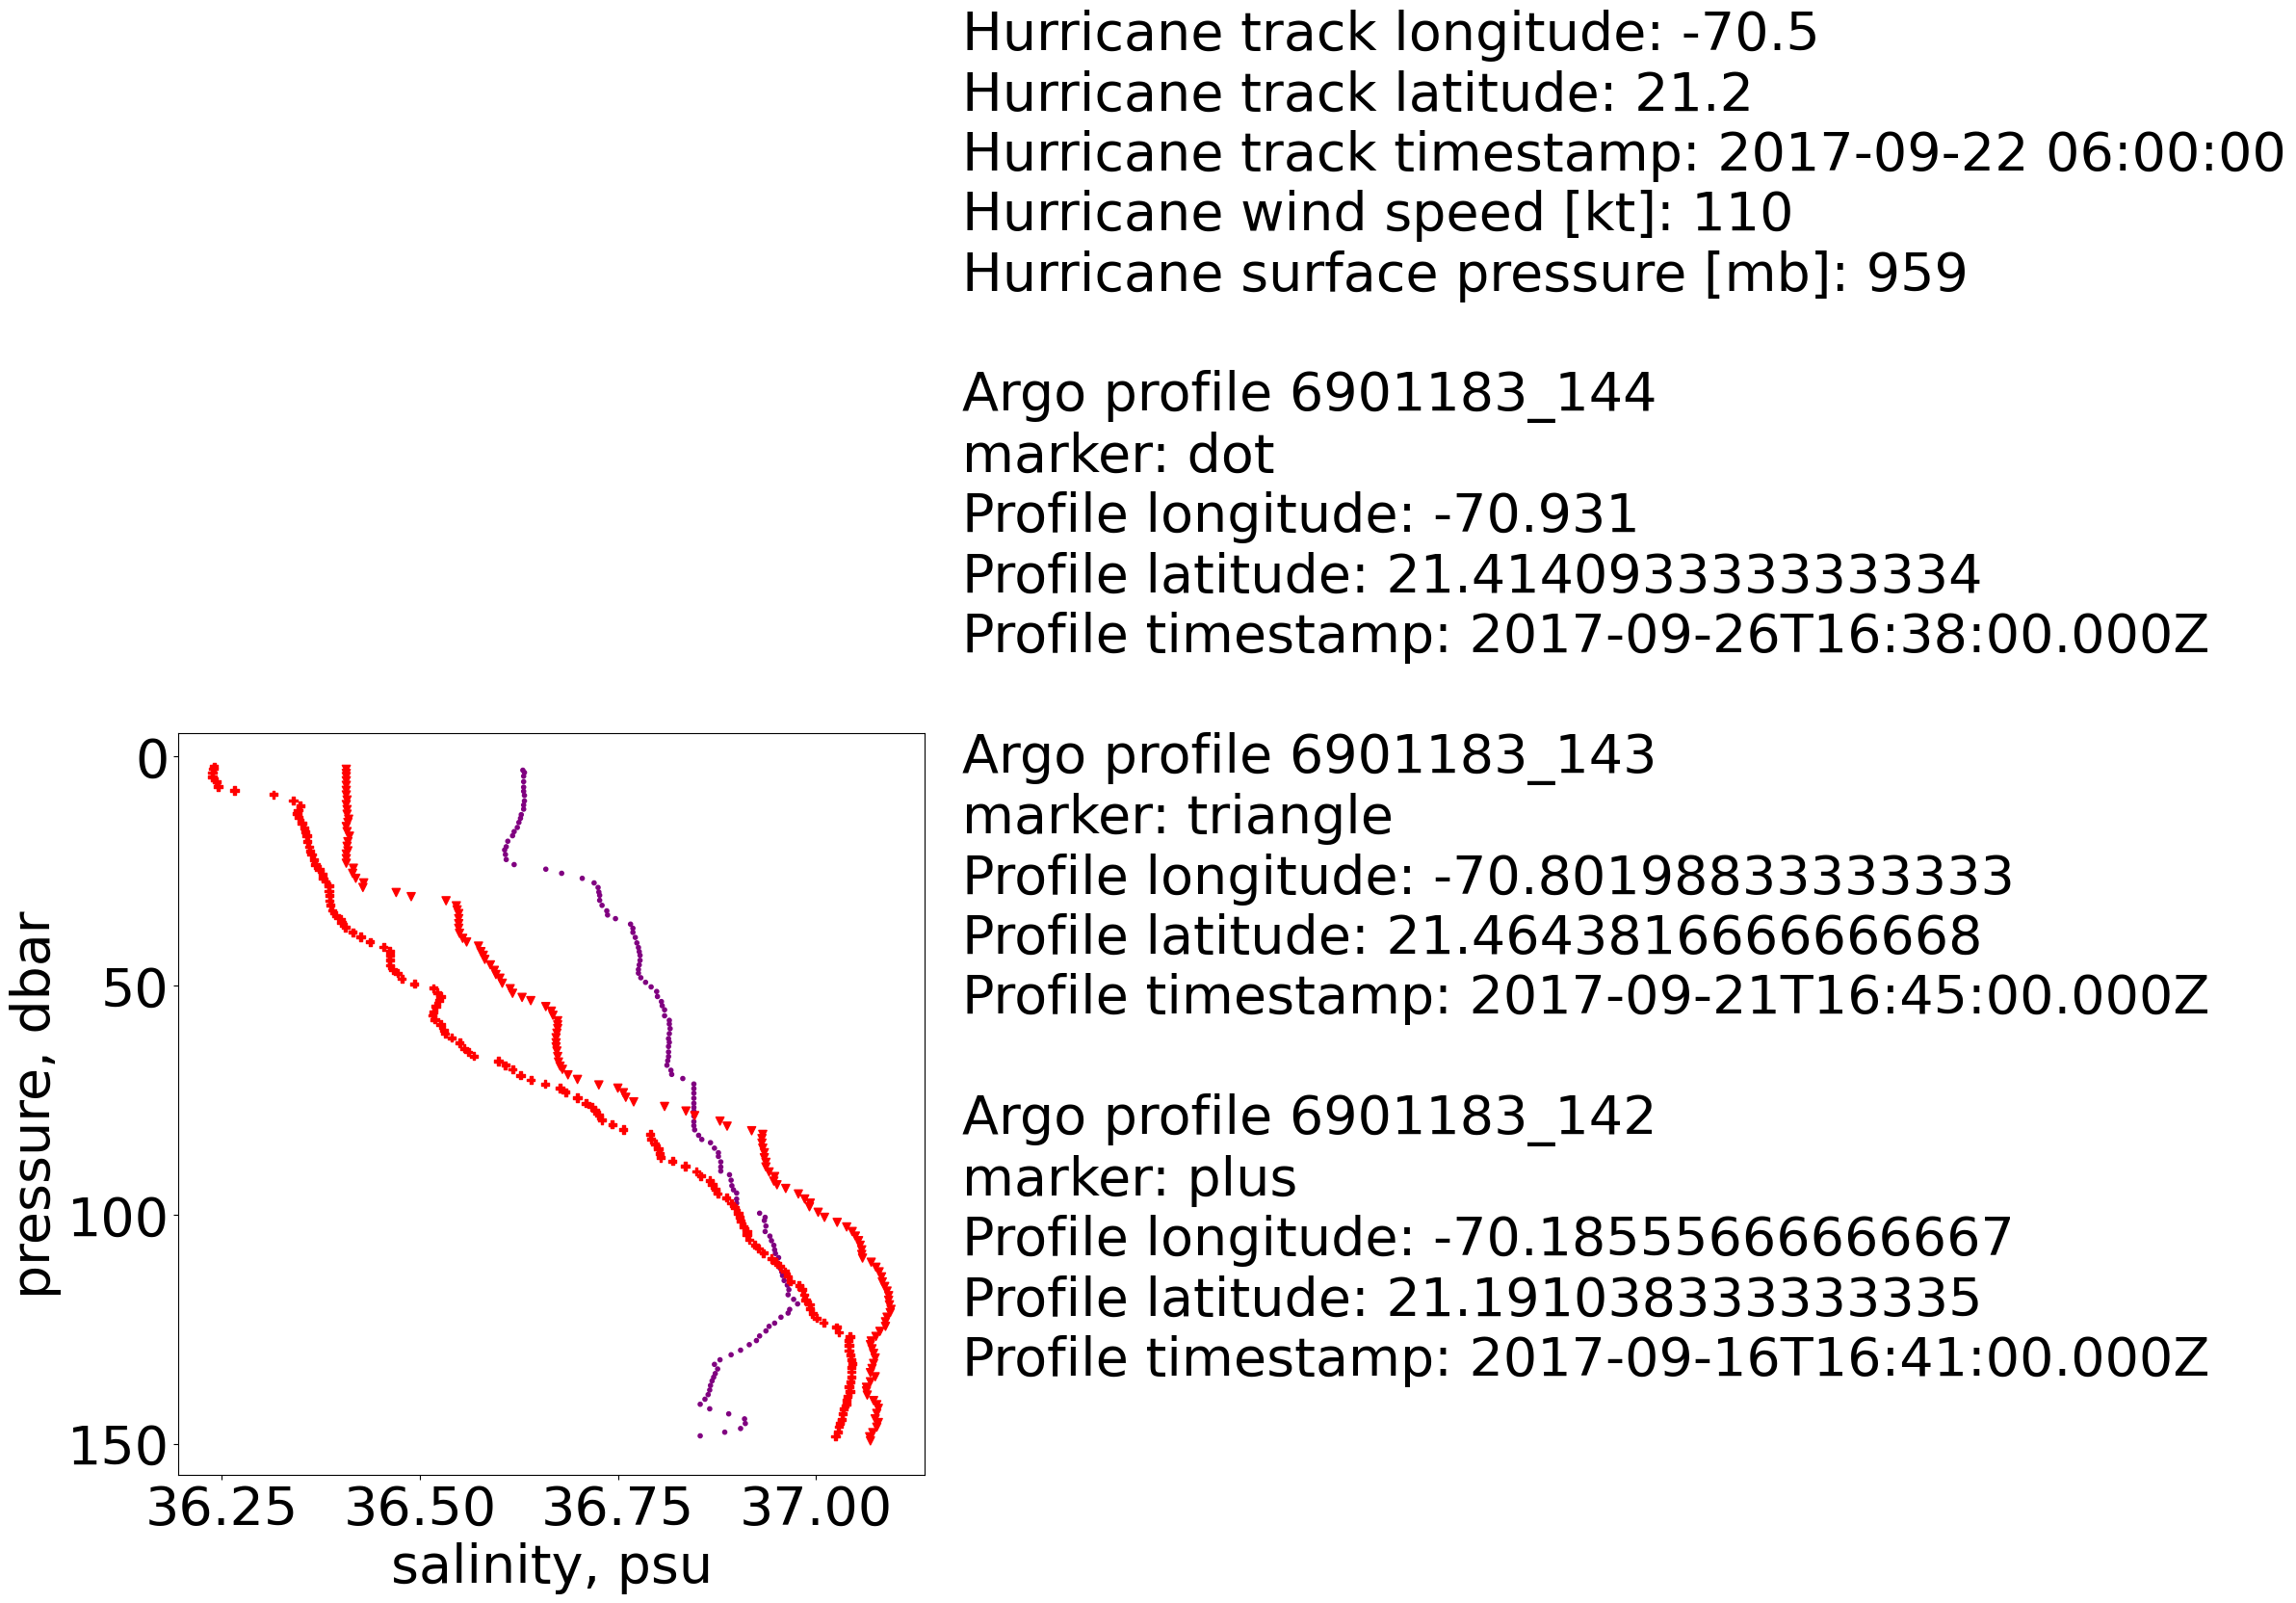

In [17]:
floats = []
colorBefore = 'red'
colorAfter = 'purple'
bracket_points = []
for i, colo in enumerate(argo_bgc):
    buddyBefore = False
    buddyAfter = False
    if colo:
        hurrtime = avh.parsetime(tc[i]['timestamp']) 
        for p in colo:
            ptime = avh.parsetime(p['timestamp'])
            buddy={
                "lon": p['geolocation']['coordinates'][0],
                "lat": p['geolocation']['coordinates'][1],
            }
            if ptime < hurrtime:
                buddy['color'] = colorBefore
                buddyBefore = True
            else:
                buddy['color'] = colorAfter
                buddyAfter = True
            floats.append(buddy)
        if buddyBefore and buddyAfter:
            bracket_points.append(i)
simple_map(tc_lon, tc_lat, secondaries=floats, z=tc_wind)
        
hurrplot([bracket_points[0]], tc=tc, argo=argo_bgc, var='temperature',colorBefore = 'red',colorAfter = 'purple') 
hurrplot([bracket_points[0]], tc=tc, argo=argo_bgc, var='salinity',colorBefore = 'red',colorAfter = 'purple')

We can also colocate with a ship-based profile in a similar manner:

In [18]:
cruise_params = {
    "cchdo_cruise": 2370,
    "woceline": "AR07W",
    "data": "temperature_bfile"
}

cruise = avh.query('cchdo', options=cruise_params, apikey=API_KEY, apiroot=API_PREFIX)

In [19]:
colo_argo_bgc = []
for cchdo_meas in cruise:
    bgc_param = {
        "center": str(cchdo_meas['geolocation']['coordinates'][0]) + ',' + str(cchdo_meas['geolocation']['coordinates'][1]),
        "radius": 50,
        "startDate": avh.parsetime((avh.parsetime(cchdo_meas['timestamp']) + timedelta(hours=-48))),
        "endDate": avh.parsetime((avh.parsetime(cchdo_meas['timestamp']) + timedelta(hours=+48))),
        "source": 'argo_bgc',
        "data": 'temperature'
    }

    prox = avh.query('argo', options=bgc_param, apikey=API_KEY, apiroot=API_PREFIX)
    
    if len(prox) != 0:
        colo_argo_bgc.append(prox)
    else:
        colo_argo_bgc.append(None)

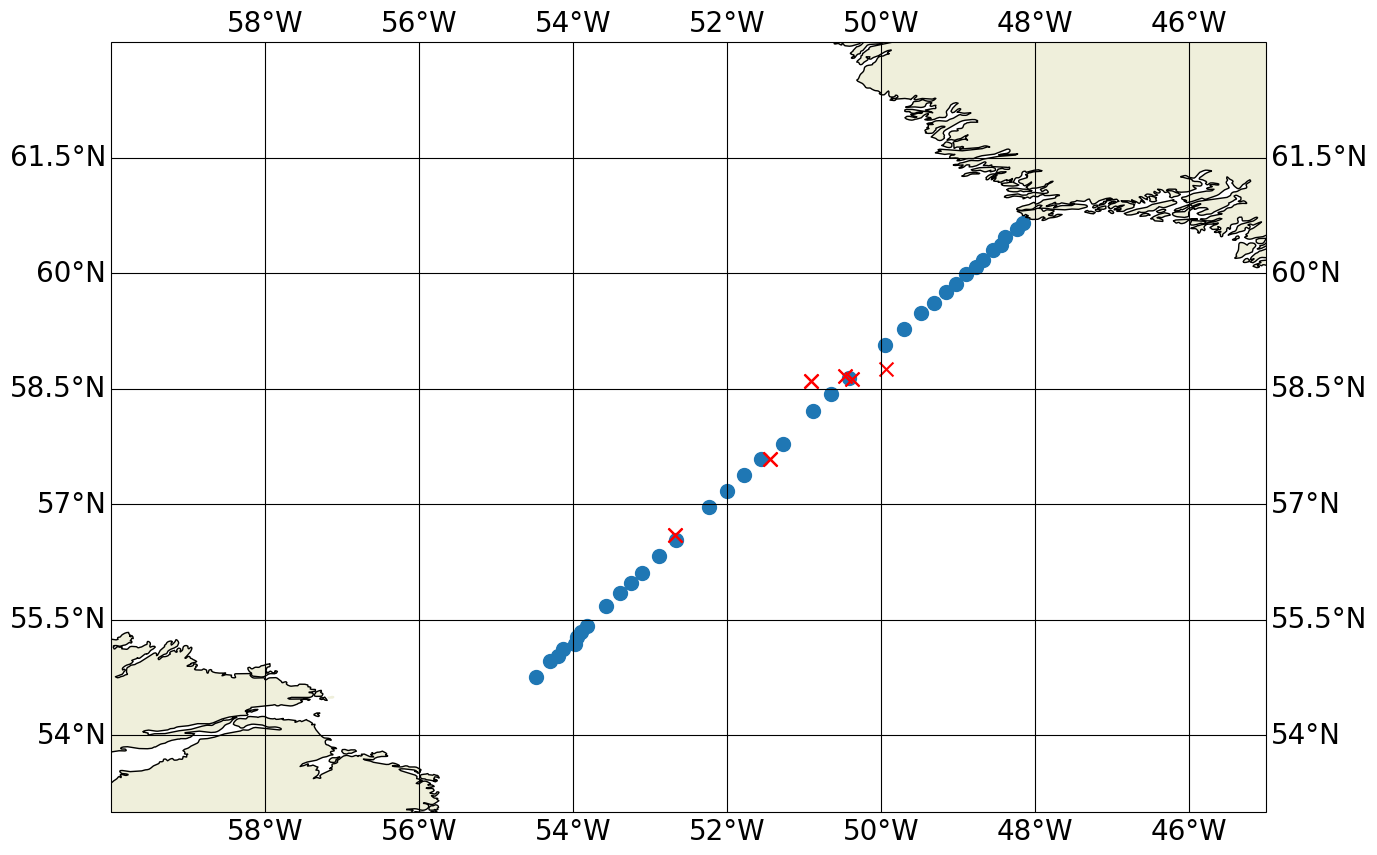

In [20]:
bgc_paths = []

for colo in colo_argo_bgc:
    if(colo is not None):
        bgc_paths.append({
            "lon": [x['geolocation']['coordinates'][0] for x in colo],
            "lat": [x['geolocation']['coordinates'][1] for x in colo]
        })
    
cchdo_longitudes = [x['geolocation']['coordinates'][0] for x in cruise]
cchdo_latitudes  = [x['geolocation']['coordinates'][1] for x in cruise]
simple_map(cchdo_longitudes,cchdo_latitudes, secondaries=bgc_paths, bounding_box=[-60,-45,53,63])


We can then plot variables of interest and compare between BGC and ship-based profiles:

<Figure size 640x480 with 0 Axes>

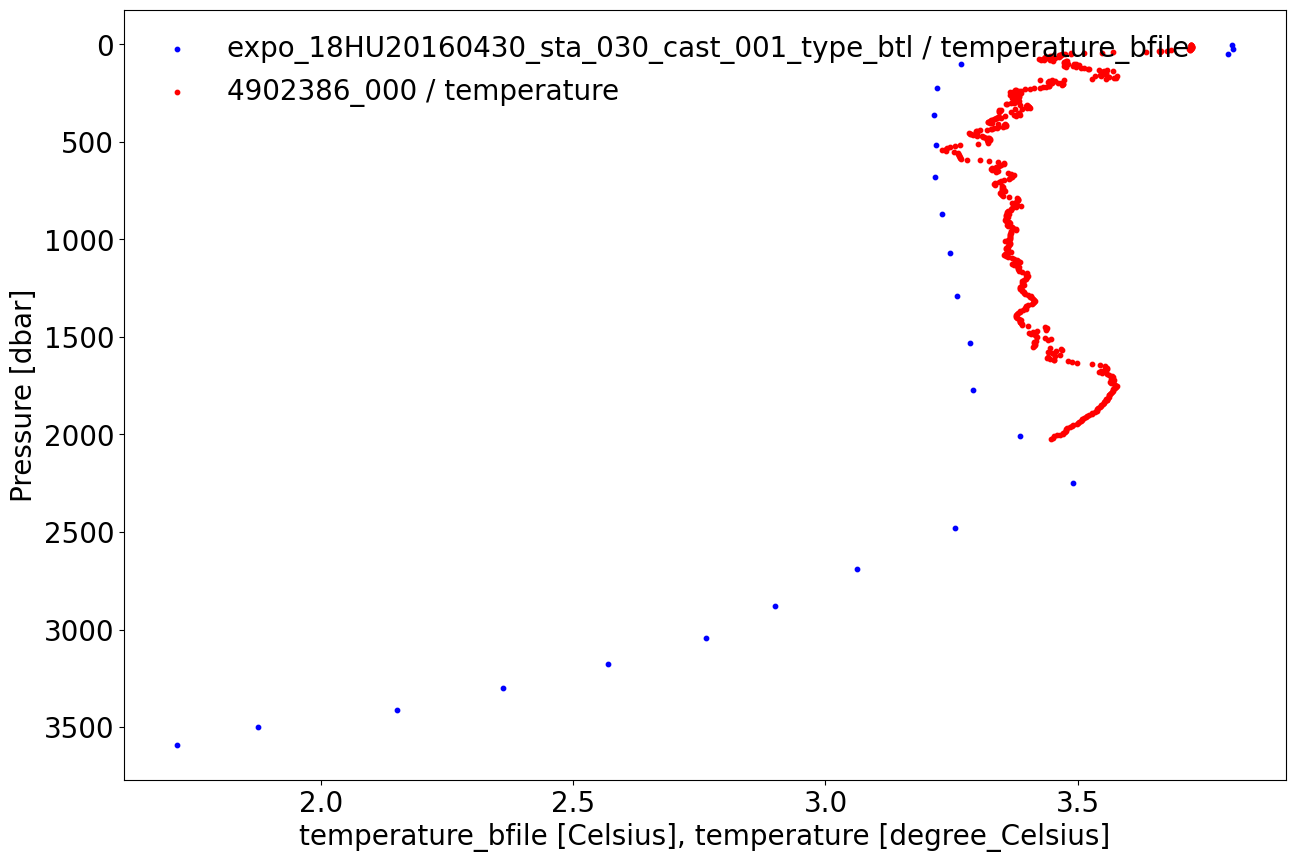

<Figure size 640x480 with 0 Axes>

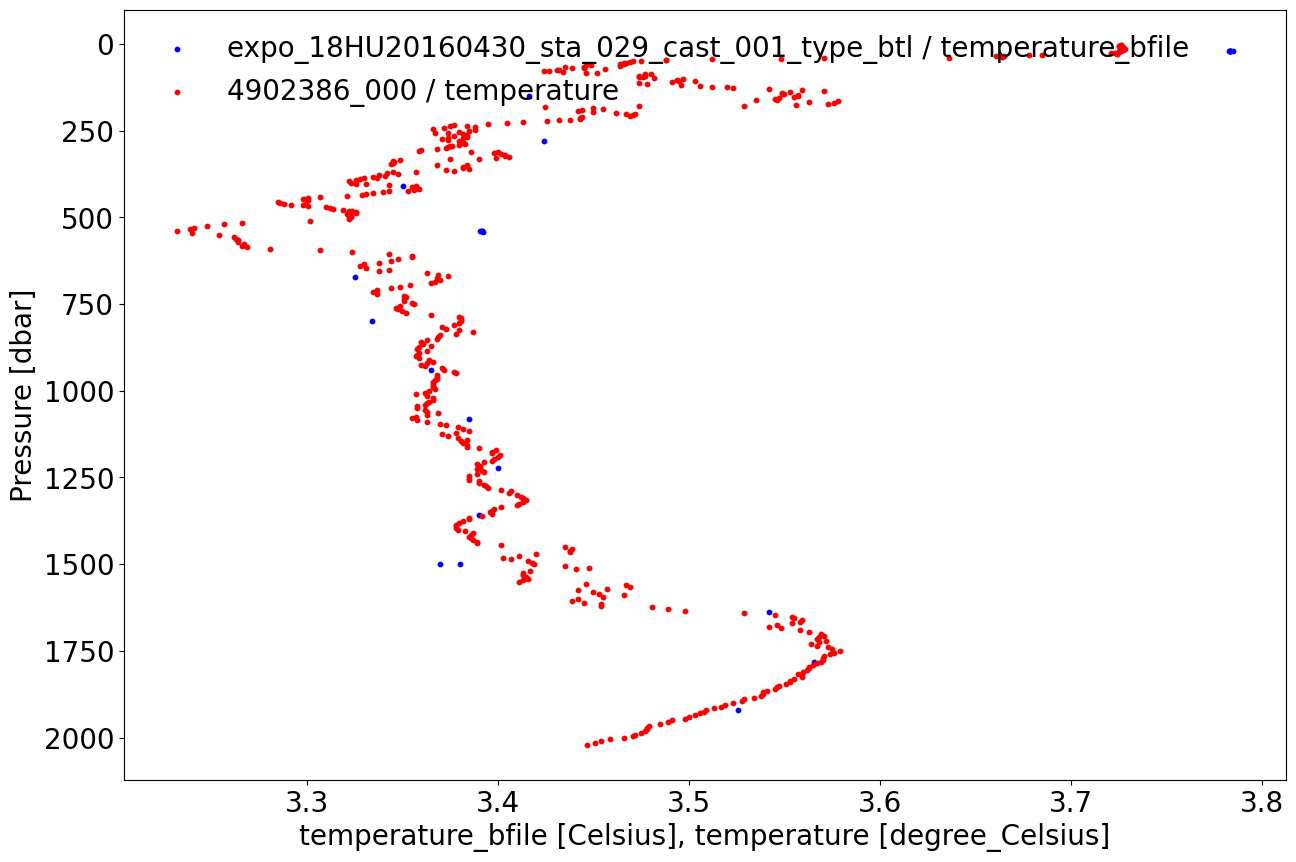

<Figure size 640x480 with 0 Axes>

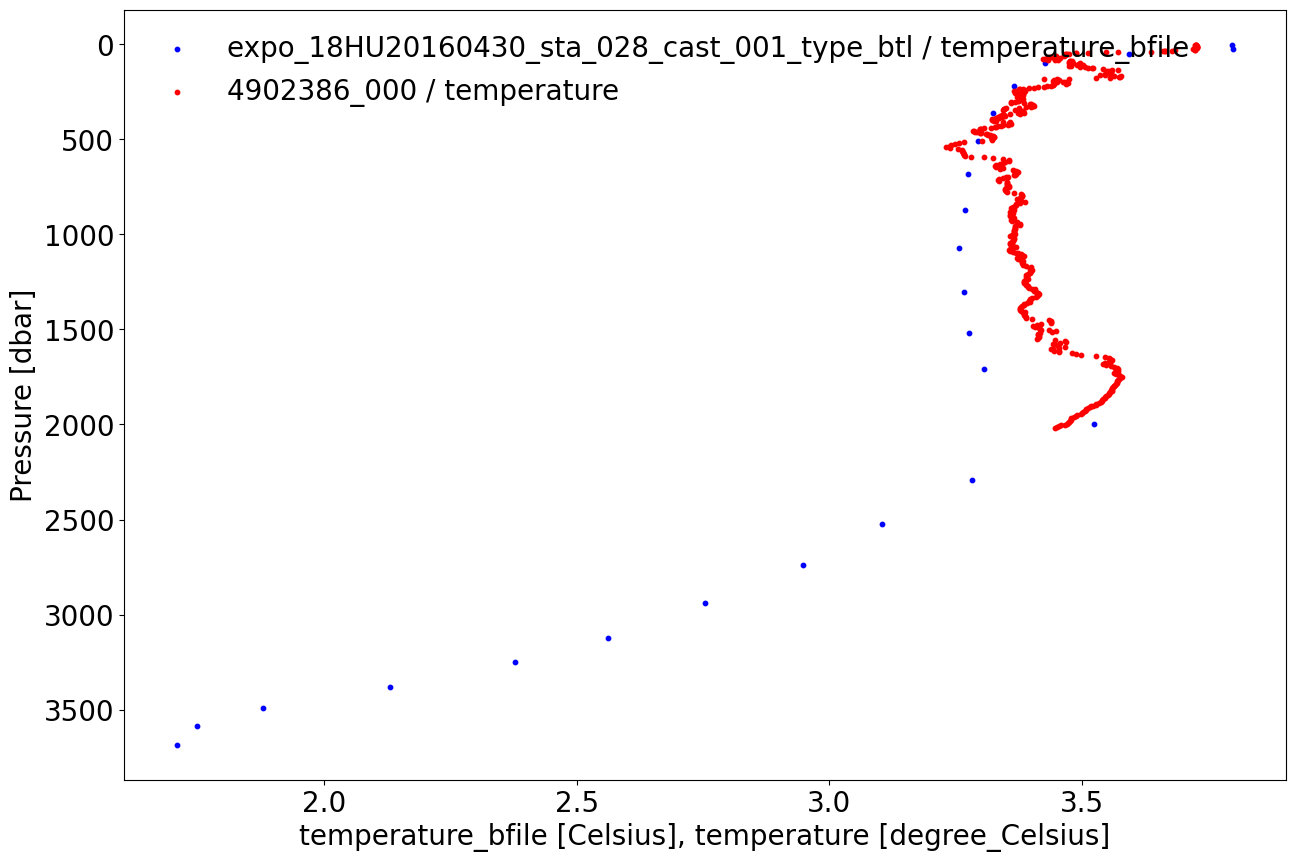

<Figure size 640x480 with 0 Axes>

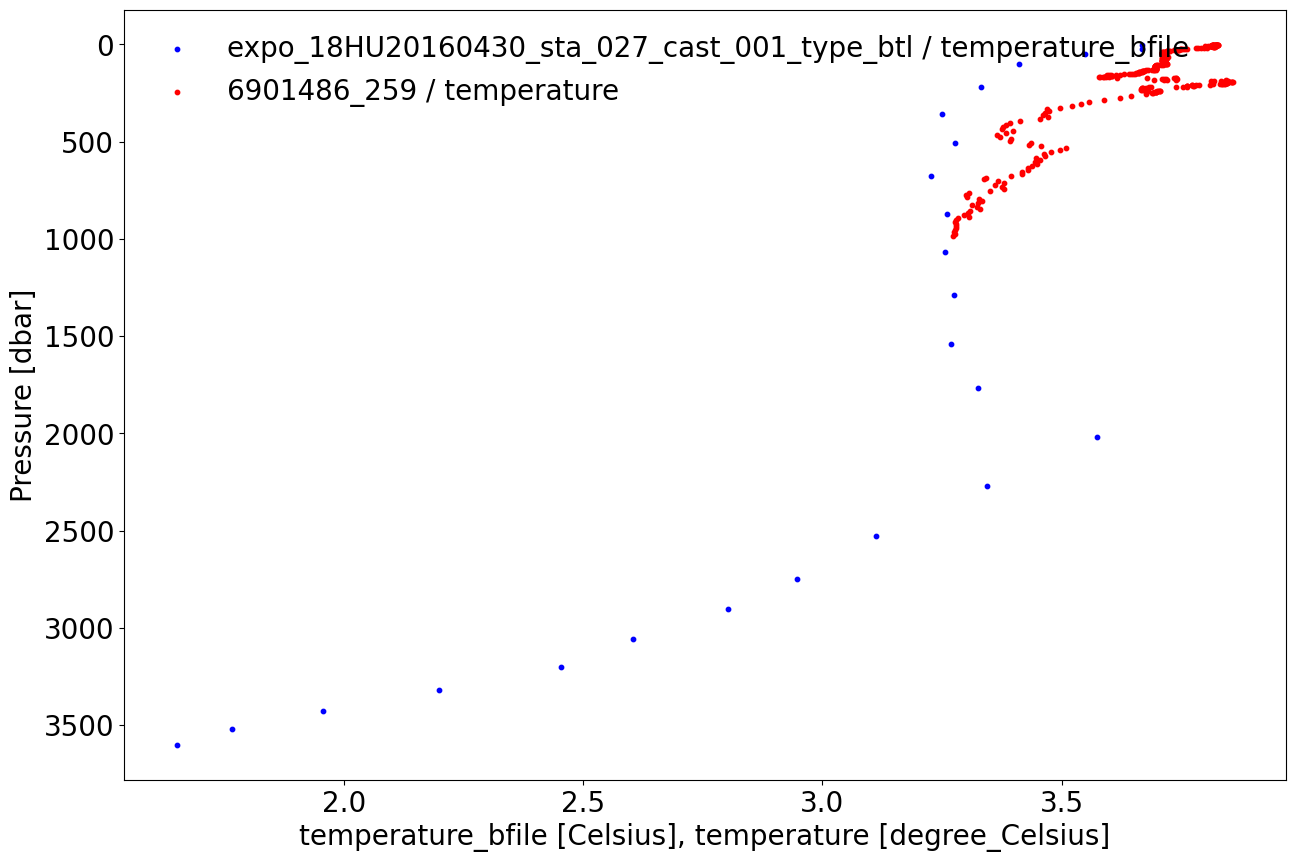

<Figure size 640x480 with 0 Axes>

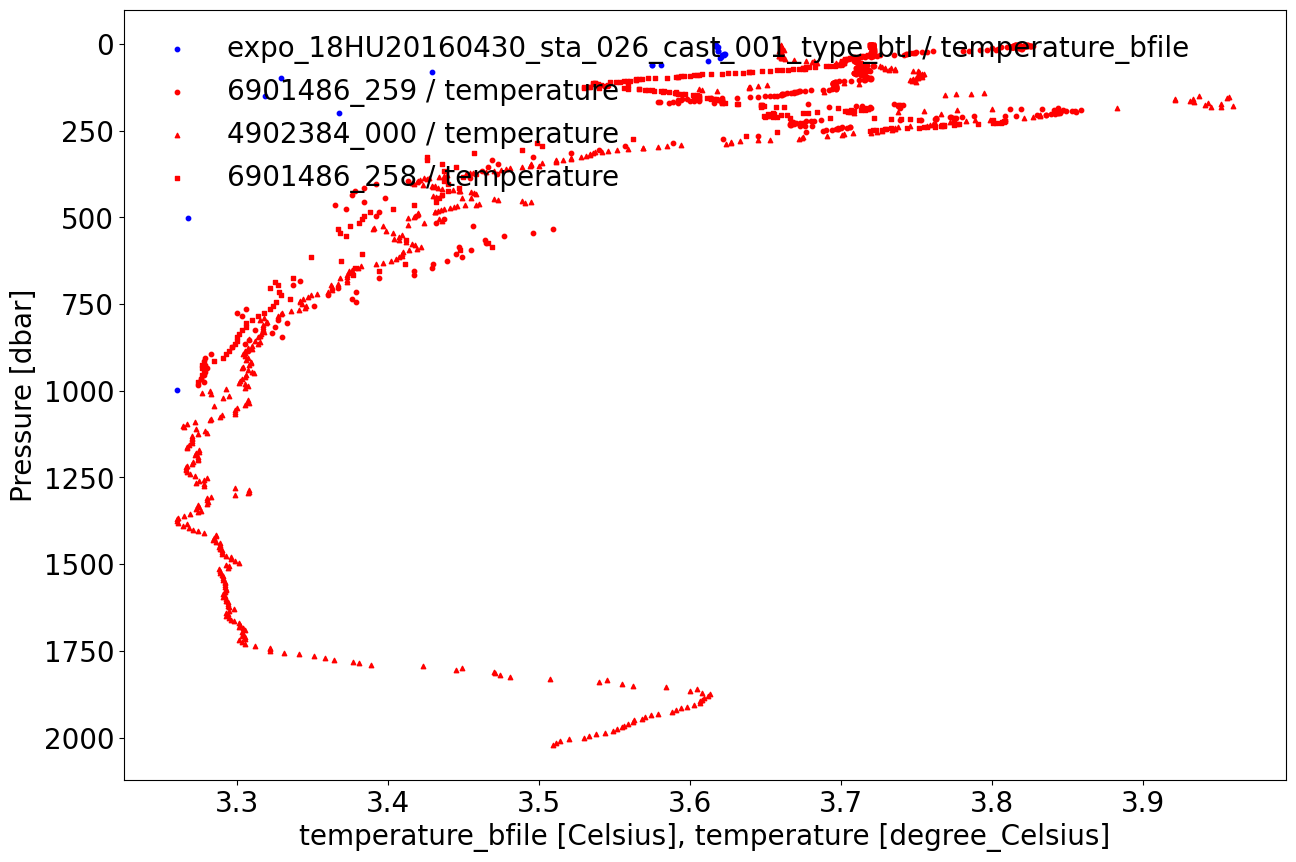

<Figure size 640x480 with 0 Axes>

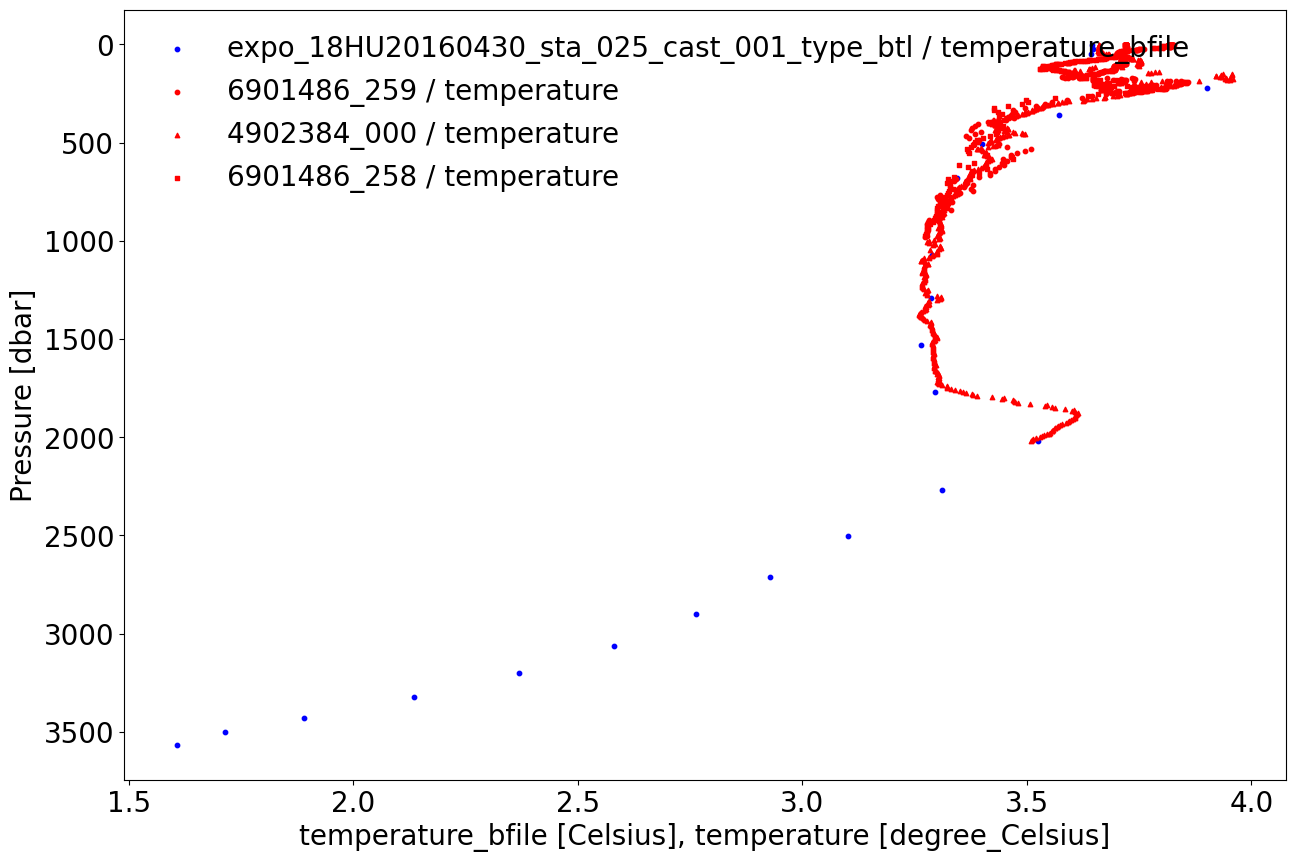

<Figure size 640x480 with 0 Axes>

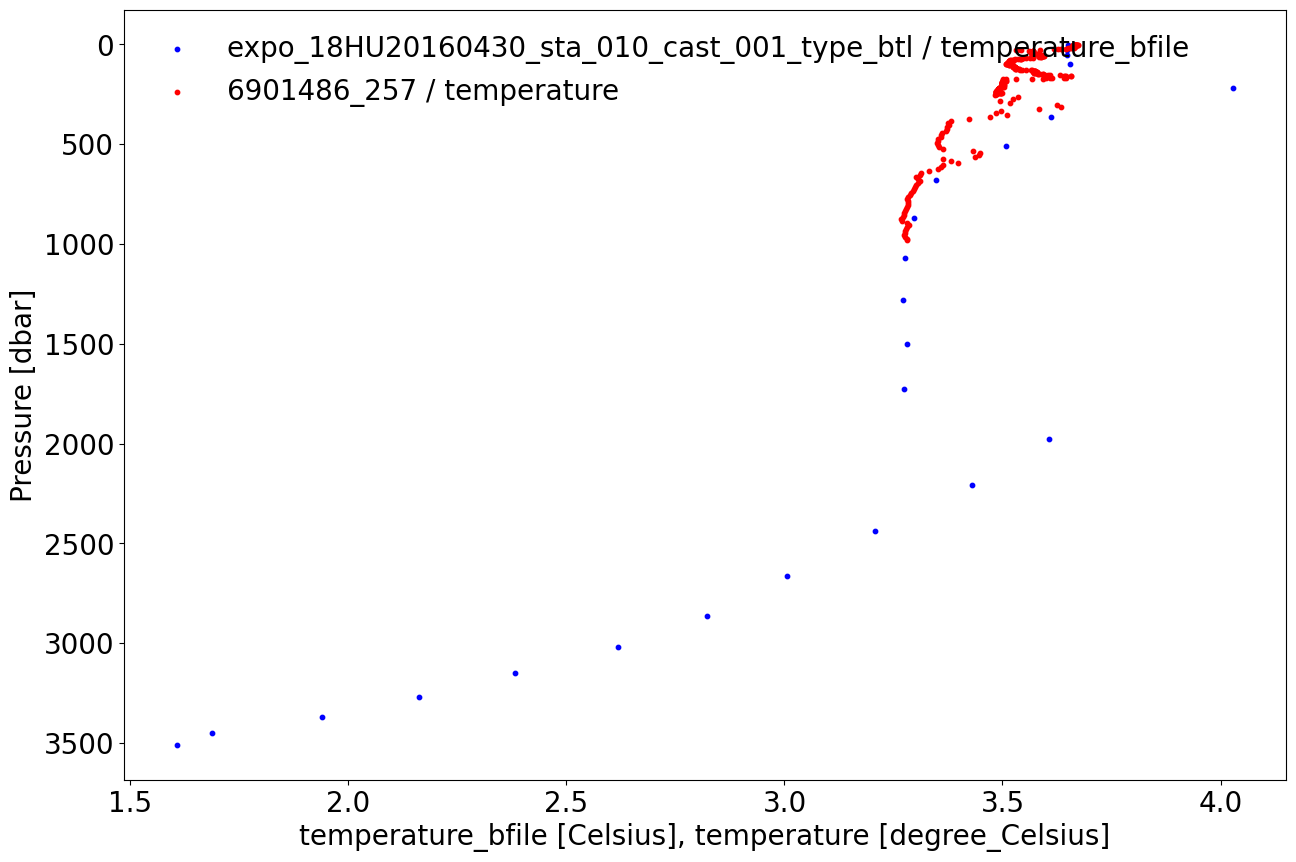

<Figure size 640x480 with 0 Axes>

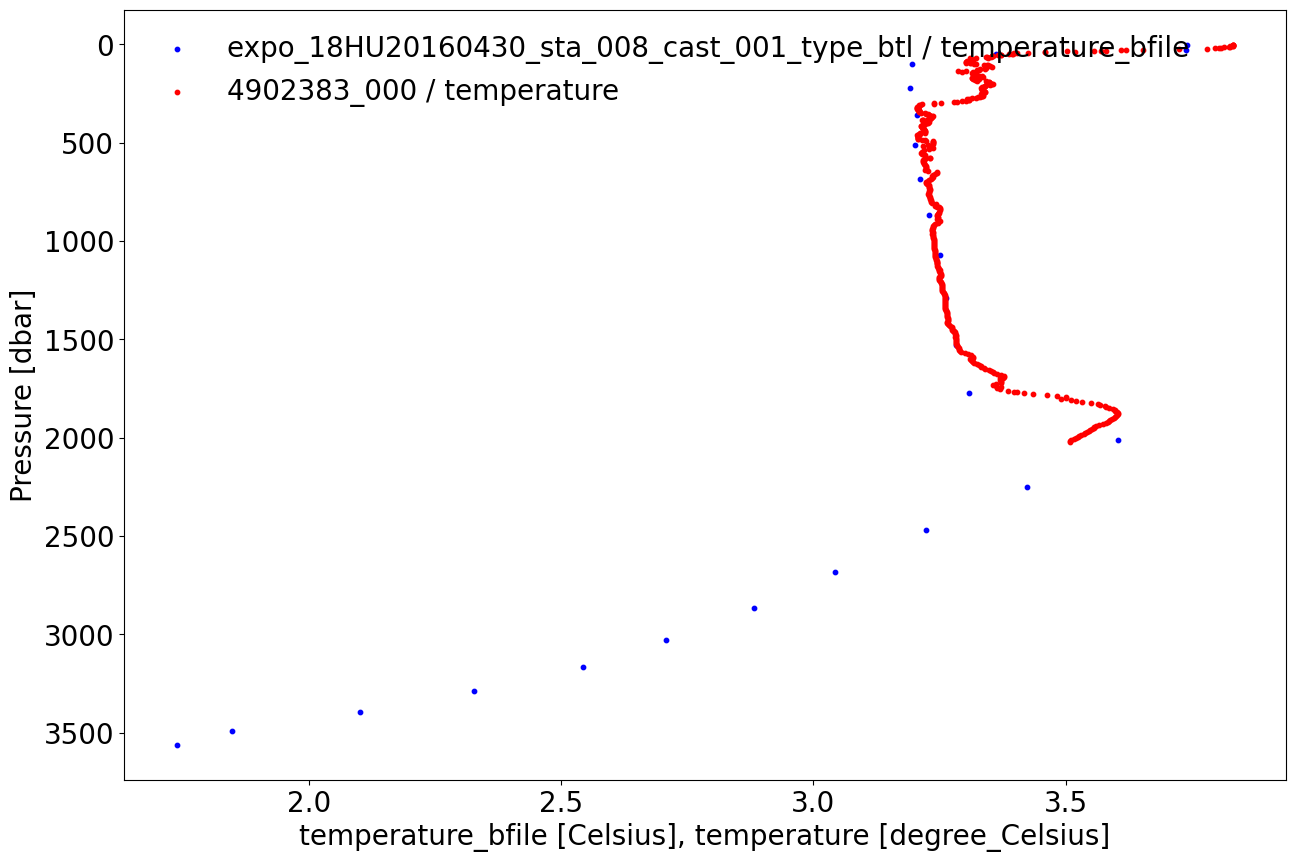

<Figure size 640x480 with 0 Axes>

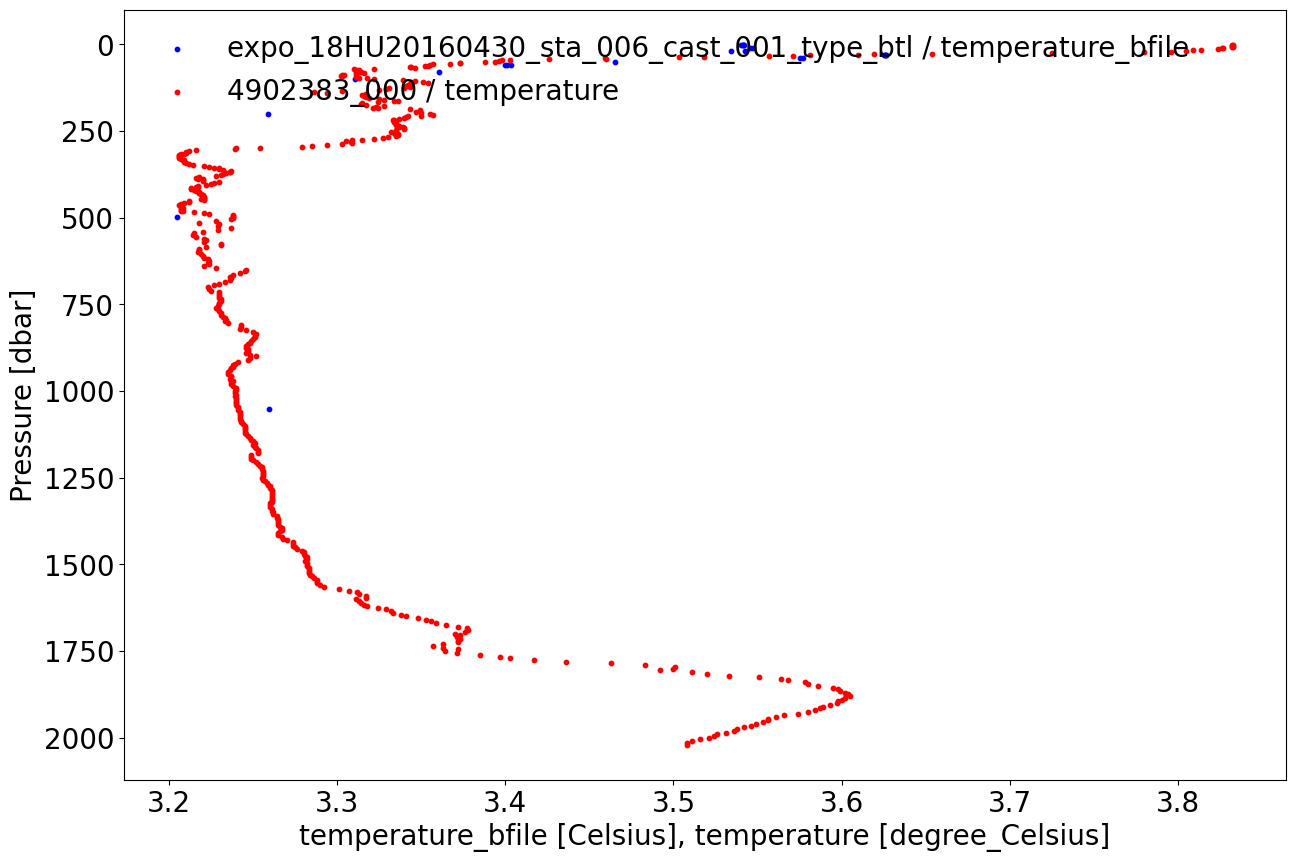

<Figure size 640x480 with 0 Axes>

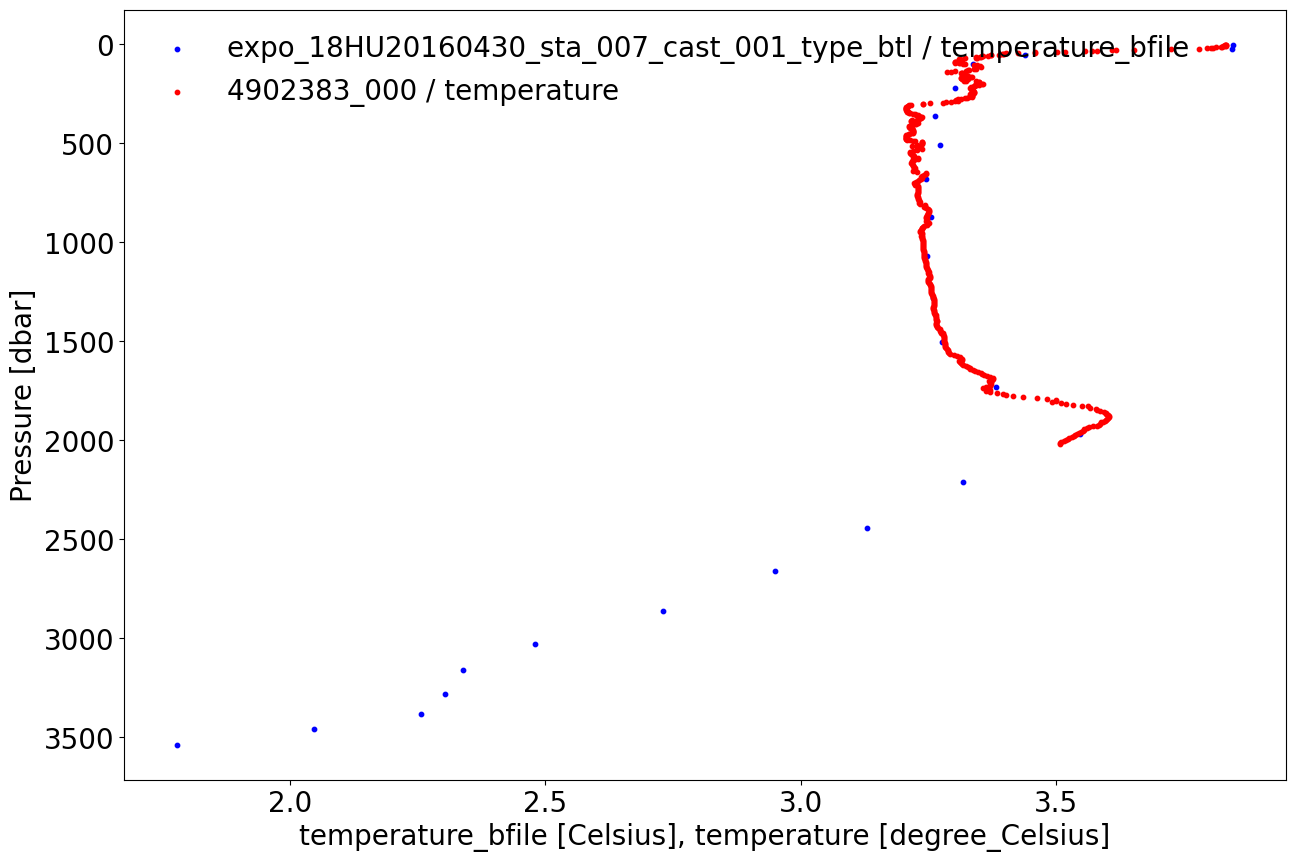

In [21]:
for i,ship_profile in enumerate(cruise):
    if colo_argo_bgc[i] is None:
        continue
    else:
        compare_plots([ship_profile], 'temperature_bfile', colo_argo_bgc[i], 'temperature')